# 03 - Single-layer NN per Ticker

This notebook trains a single-layer feedforward neural network for each ticker in each sector.

Training AAPL...


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


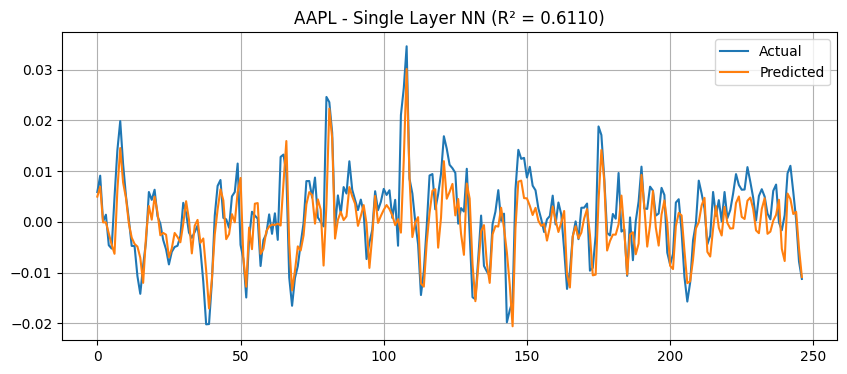

Training MSFT...


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


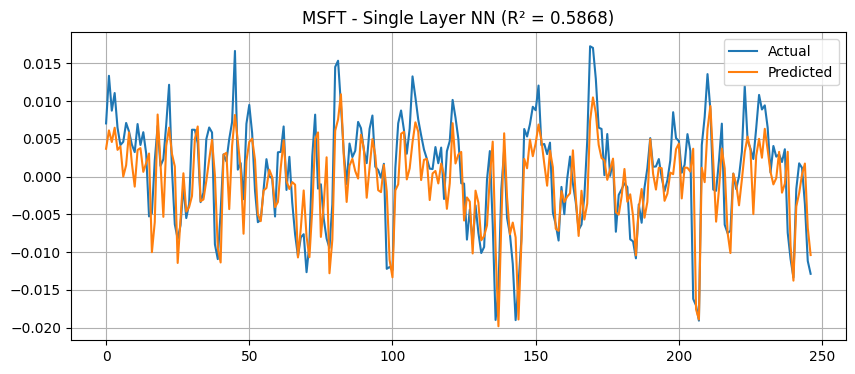

Training JPM...


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


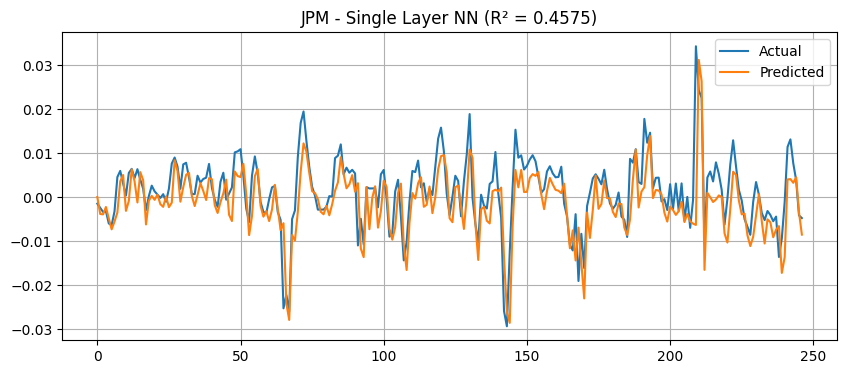

Training BAC...


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


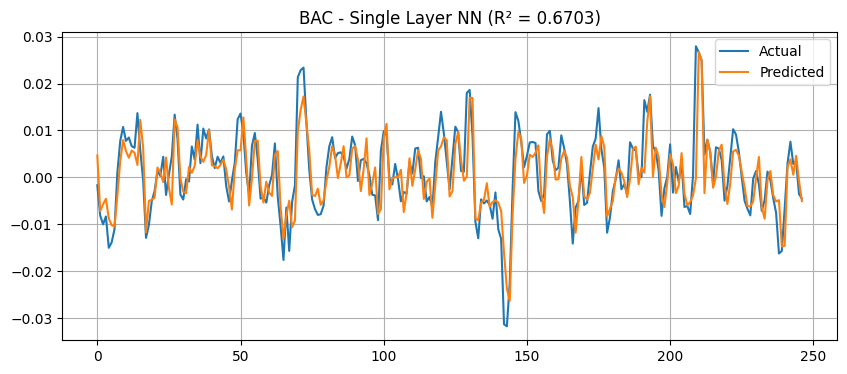

Training XOM...


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


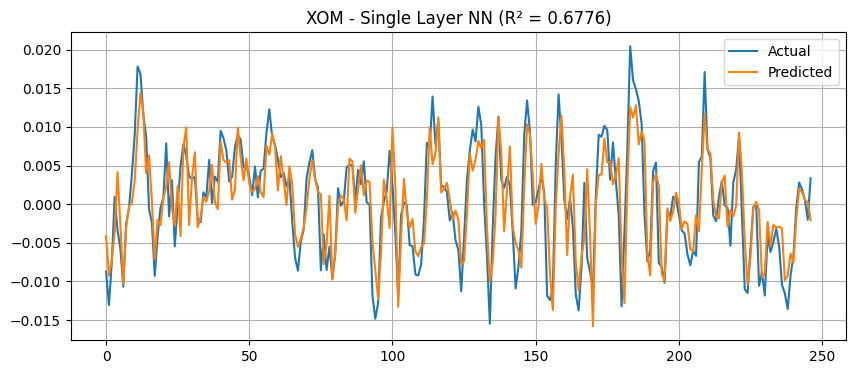

Training CVX...


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


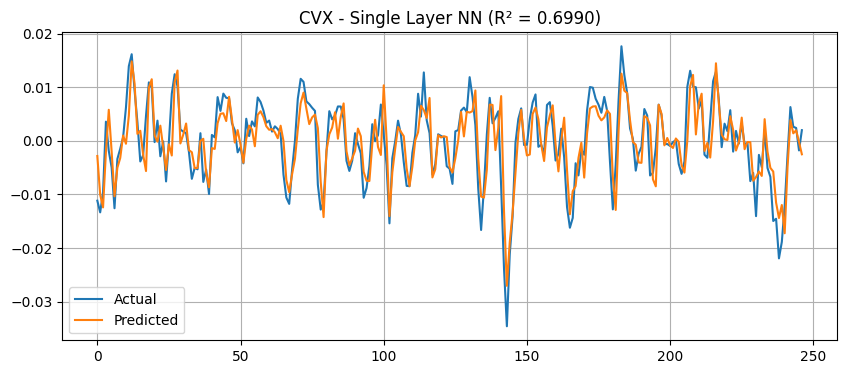


SUMMARY
AAPL: MSE = 0.000027, RMSE = 0.005182, R² = 0.6110
MSFT: MSE = 0.000020, RMSE = 0.004518, R² = 0.5868
JPM: MSE = 0.000034, RMSE = 0.005841, R² = 0.4575
BAC: MSE = 0.000024, RMSE = 0.004901, R² = 0.6703
XOM: MSE = 0.000016, RMSE = 0.004048, R² = 0.6776
CVX: MSE = 0.000017, RMSE = 0.004159, R² = 0.6990


In [ ]:
import sys
sys.path.append('..') # Add parent directory to Python path to import modules from parent directory
import json # For saving feature names to JSON files
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations
import os # For file system operations
import random # For setting random seed
import tensorflow as tf # Deep learning framework
from sklearn.model_selection import train_test_split # For splitting data into train and test sets
from sklearn.preprocessing import StandardScaler # For standardizing features to zero mean and unit variance
from sklearn.feature_selection import mutual_info_regression # For feature selection using information theory
from sklearn.metrics import mean_squared_error, r2_score # For model evaluation
import matplotlib.pyplot as plt # For data visualization
from tensorflow.keras.models import Sequential # For creating sequential neural network models
from tensorflow.keras.layers import Dense # For creating fully connected neural network layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # For optimizing training process
import logging # For controlling log output

# Suppress TensorFlow warnings to keep notebook output clean
# Level 2 hides info and warnings but shows errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Set random seeds for reproducibility across runs
# This ensures that random operations like weight initialization and train/test splits are consistent
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# List of stock tickers representing different market sectors
# AAPL, MSFT: Technology
# JPM, BAC: Banking/Finance
# XOM, CVX: Energy/Oil
tickers = ['AAPL', 'MSFT', 'JPM', 'BAC', 'XOM', 'CVX']
results = {} # Dictionary to store performance metrics for each ticker

# Iterate through each ticker to build individual models
for ticker in tickers:
    print(f"Training {ticker}...")
    # Load processed price data for current ticker
    # Parse_dates ensures that the date index is properly formatted
    df = pd.read_csv(f'../data/processed/{ticker}_processed.csv', index_col='Date', parse_dates=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce') # Convert 'Close' column to numeric, handling any errors

    # ------ Feature Engineering: Technical Indicators ------
    # Calculate daily percentage change in closing price
    df['Return'] = df['Close'].pct_change()
    
    # Create lagged returns (previous 1-5 days) to capture short-term price patterns
    # These features help the model understand recent market momentum
    for i in range(1, 6):
        df[f'Lag_{i}'] = df['Return'].shift(i)
    
    # 10-day price momentum: difference between current price and price 10 days ago
    # Captures medium-term trend direction
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    # Calculate RSI (Relative Strength Index) - popular technical indicator
    # RSI measures the magnitude of recent price changes to evaluate overbought/oversold conditions
    delta = df['Close'].diff() # Daily price difference
    gain = delta.clip(lower=0).rolling(14).mean() # Average gains over 14 days (standard RSI period)
    loss = -delta.clip(upper=0).rolling(14).mean() # Average losses over 14 days
    rs = gain / (loss.replace(0, np.finfo(float).eps)) # Relative strength (gain/loss ratio), avoiding division by zero
    df['RSI'] = 100 - (100 / (1 + rs)) # RSI formula: scales result to 0-100 range

    # Calculate MACD (Moving Average Convergence Divergence)
    # MACD is a trend-following momentum indicator showing relationship between two moving averages
    ema12 = df['Close'].ewm(span=12, adjust=False).mean() # 12-day exponential moving average
    ema26 = df['Close'].ewm(span=26, adjust=False).mean() # 26-day exponential moving average
    df['MACD'] = ema12 - ema26 # MACD line is difference between these EMAs
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean() # 9-day EMA of MACD (signal line)

    # ------ Target Variable Creation ------
    # Log returns are preferred in finance as they're additive over time and more normally distributed
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    # Target: 3-day smoothed forward log return
    # Shift(-1) looks one day ahead, rolling(3).mean() smooths over 3 days to reduce noise
    df['Target'] = df['LogReturn'].shift(-1).rolling(3).mean()

    # Remove rows with NaN values resulting from the lag and rolling operations
    df.dropna(inplace=True)

    # ------ Feature Selection using Mutual Information ------
    # Mutual information measures how much information one variable provides about another
    # It can capture non-linear relationships unlike correlation
    all_features = df.drop(columns=['Target']) # All columns except target
    target = df['Target']

    # Calculate mutual information between each feature and target
    mi_scores = mutual_info_regression(all_features, target)
    # Convert to Series, sort by MI score, and select top 10 most informative features
    top_features = pd.Series(mi_scores, index=all_features.columns).sort_values(ascending=False).head(10).index.tolist()

    # Create feature matrix X and target vector y using only selected features
    X = all_features[top_features]
    y = target

    # ------ Target Normalization ------
    # Normalize target to zero mean and unit standard deviation
    # This improves neural network training stability and convergence speed
    y_mean, y_std = y.mean(), y.std()
    y = (y - y_mean) / y_std

    # ------ Data Splitting ------
    # Split data chronologically (no shuffle) to maintain time-series integrity
    # Use 80% for training and 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # ------ Feature Scaling ------
    # Standardize features to zero mean and unit variance
    # Neural networks perform better with standardized inputs
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # Fit scaler on training data only to prevent data leakage
    X_test_scaled = scaler.transform(X_test) # Apply same transformation to test data

    # ------ Model Architecture ------
    # Create a single-layer neural network (linear model)
    # Single dense layer with one output neuron makes this equivalent to linear regression
    model = Sequential([
        Dense(1, input_shape=(X_train_scaled.shape[1],))
    ])
    model.compile(optimizer='adam', loss='mse') # Adam optimizer and mean squared error loss function

    # ------ Training Callbacks ------
    # Early stopping to prevent overfitting
    # Stops training when validation loss doesn't improve for 15 epochs
    early_stop = EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')
    
    # Learning rate reduction
    # Reduces learning rate by half when validation loss plateaus for 5 epochs
    # Helps fine-tune model training when approaching optimal weights
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    # ------ Model Training ------
    # Train for up to 200 epochs with 20% of training data used for validation
    # verbose=0 suppresses training output for cleaner notebook
    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, verbose=0,
              callbacks=[early_stop, reduce_lr])

    # ------ Save Model and Feature List ------
    # Create directory if it doesn't exist
    os.makedirs('../models/saved_model', exist_ok=True)
    # Save trained model in Keras format
    model.save(f'../models/saved_model/{ticker}_single_layer_nn.keras')
    # Save list of selected features for later use in prediction
    with open(f'../models/saved_model/{ticker}_single_layer_features.json', 'w') as f:
        json.dump(top_features, f)
    
    # ------ Generate Predictions ------
    # Make predictions on test set
    y_pred = model.predict(X_test_scaled, verbose=0).flatten() # Suppress prediction output
    
    # ------ De-normalize Predictions and Actual Values ------
    # Convert standardized values back to original scale for meaningful evaluation
    y_pred = y_pred * y_std + y_mean
    y_test_actual = y_test * y_std + y_mean

    # ------ Calculate Performance Metrics ------
    mse = mean_squared_error(y_test_actual, y_pred) # Mean Squared Error
    rmse = np.sqrt(mse) # Root Mean Squared Error - more interpretable in original units
    r2 = r2_score(y_test_actual, y_pred) # R-squared - proportion of variance explained by model
    results[ticker] = (mse, rmse, r2) # Store metrics for later comparison

    # ------ Visualize Results ------
    # Plot actual vs predicted values for visual assessment
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_actual.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{ticker} - Single Layer NN (R² = {r2:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------ Summary Output ------
# Print performance metrics for all tickers for comparison
print("\nSUMMARY")
for ticker, (mse, rmse, r2) in results.items():
    print(f"{ticker}: MSE = {mse:.6f}, RMSE = {rmse:.6f}, R² = {r2:.4f}")